In [21]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

In [22]:
!pip install kaggle

In [23]:
from google.colab import files
files.upload()  # загрузи kaggle.json через интерфейс

!mkdir -p ~/.config/kaggle
!cp kaggle.json ~/.config/kaggle/
!chmod 600 ~/.config/kaggle/kaggle.json

KeyboardInterrupt: 

In [ ]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting

In [8]:
!unzip walmart-recruiting-store-sales-forecasting.zip

Archive:  walmart-recruiting-store-sales-forecasting.zip
replace features.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace sampleSubmission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace stores.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


Описание набора данных

Вам предоставлены исторические данные о продажах в 45 магазинах Walmart, расположенных в разных регионах. Каждый магазин состоит из нескольких отделов, и вам необходимо спрогнозировать продажи по каждому отделу.

Кроме того, Walmart проводит несколько акций со скидками в течение года. Эти скидки предшествуют важным праздникам, четыре из которых — Супербоул, День труда, День благодарения и Рождество. Недели, включающие эти праздники, имеют в пять раз больший вес при оценке, чем недели без праздников. Одной из задач этого конкурса является моделирование влияния скидок на эти праздничные недели в отсутствие полных/идеальных исторических данных.

stores.csv

В этом файле содержится анонимная информация о 45 магазинах с указанием типа и размера магазина.

train.csv

Это исторические данные по обучению, охватывающие период с 05.02.2010 по 01.11.2012. В этом файле вы найдете следующие поля:

Магазин - номер магазина

Dept - номер отдела

Дата - неделя

Weekly_Sales — продажи в данном отделе в данном магазине

IsHoliday — является ли неделя специальной праздничной неделей


особенности.csv

Этот файл содержит дополнительные данные о деятельности магазина, отдела и региона за указанные даты. Он содержит следующие поля:

Магазин - номер магазина

Дата - неделя

Температура - средняя температура в регионе

Fuel_Price - стоимость топлива в регионе

MarkDown1-5 — анонимные данные о скидках, проводимых Walmart. Данные MarkDown доступны только с ноября 2011 года и не для всех магазинов. Любое отсутствующее значение отмечено как «NA».

ИПЦ — индекс потребительских цен

Безработица - уровень безработицы

IsHoliday — является ли неделя специальной праздничной неделей

Для удобства четыре праздника в наборе данных попадают в следующие недели (не все праздники включены в данные):

Суперкубок: 12 февраля 2010 г., 11 февраля 2011 г., 10 февраля 2012 г., 8 февраля 2013 г.

День труда: 10 сентября 2010 г., 9 сентября 2011 г., 7 сентября 2012 г., 6 сентября 2013 г.

День благодарения: 26 ноября 2010 г., 25 ноября 2011 г., 23 ноября 2012 г., 29 ноября 2013 г.

Рождество: 31 декабря 2010 г., 30 декабря 2011 г., 28 декабря 2012 г., 27 декабря 2013 г.

In [9]:
!unzip /content/features.csv.zip
!unzip /content/train.csv.zip

Archive:  /content/features.csv.zip
replace features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: features.csv            
Archive:  /content/train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [10]:
train = pd.read_csv("train.csv", parse_dates=["Date"])
features = pd.read_csv("features.csv", parse_dates=["Date"])
stores = pd.read_csv("stores.csv")


In [11]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


все данные недельные

In [12]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [13]:
features['Temperature'].describe()

,Temperature
count,8190.000000
mean,59.356198
std,18.678607
min,-7.290000
25%,45.902500
50%,60.710000
75%,73.880000
max,101.950000


вывод - температура по фаренгейту

In [14]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [16]:
train.describe()

,Store,Dept,Date,Weekly_Sales
count,421570.000000,421570.000000,421570,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000
std,12.785297,30.492054,NaN,22711.183519


минусы - это возвраты

давайте выберем самый успешный отдел и магазин, который дал больше всего прибыли за все время

In [17]:
train.groupby(['Store','Dept'])['Weekly_Sales'].sum().sort_values()

,,Weekly_Sales
Store,Dept,
35,47,-3567.18
1,47,-2562.00
10,47,-2329.00
42,72,-1209.93
45,47,-1061.04
...,...,...
4,92,22789210.43
13,92,23170876.20
20,92,23542625.04


Магазин 14, отдел 92

In [18]:
df = train.query('Store == 14 and Dept == 92')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
137206,14,92,2010-02-05,293966.05,False
137207,14,92,2010-02-12,151901.21,True
137208,14,92,2010-02-19,192282.19,False
137209,14,92,2010-02-26,205250.96,False
137210,14,92,2010-03-05,214383.07,False


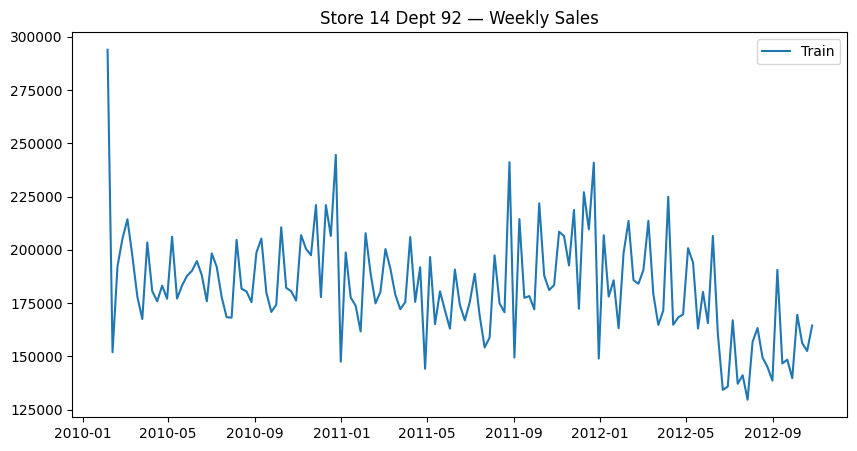

In [19]:
# Посмотрим на график
plt.figure(figsize=(10,5))
plt.plot(df["Date"], df["Weekly_Sales"], label="Train")
plt.legend()
plt.title("Store 14 Dept 92 — Weekly Sales")
plt.show()


In [20]:
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings("ignore")

In [24]:
series = df['Weekly_Sales']


# --- 3. Тест Дики-Фуллера (ADF) ---
print("=== Тест Дики-Фуллера (ADF) ===")
adf_result = adfuller(series, autolag='AIC')
adf_pvalue = adf_result[1]
print(f'ADF p-значение: {adf_pvalue:.6f}')
if adf_pvalue < 0.05:
    print("✅ Ряд стационарен (H0 отвергнут)")
else:
    print("❌ Ряд нестационарен (H0 не отвергнут)")

# --- 4. KPSS-тест ---
print("\n=== KPSS-тест ===")
try:
    kpss_stat, kpss_pvalue, lags, crit_vals = kpss(series, regression='c', nlags='auto')
    print(f'KPSS p-значение: {kpss_pvalue:.6f}')
    if kpss_pvalue > 0.05:
        print("✅ Ряд стационарен (H0 не отвергнут)")
    else:
        print("❌ Ряд нестационарен (H0 отвергнут)")
except Exception as e:
    print("Ошибка при выполнении KPSS-теста:", e)

# --- Дополнительно: краткий итог ---
print("\n--- Сводка ---")
if adf_pvalue < 0.05 and kpss_pvalue > 0.05:
    print("📌 Вывод: Ряд, скорее всего, стационарен.")
elif adf_pvalue >= 0.05 and kpss_pvalue <= 0.05:
    print("📌 Вывод: Ряд, скорее всего, нестационарен.")
else:
    print("📌 Вывод: Тесты дают противоречивые результаты. Возможна необходимость дифференцирования.")


=== Тест Дики-Фуллера (ADF) ===
ADF p-значение: 0.677022
❌ Ряд нестационарен (H0 не отвергнут)

=== KPSS-тест ===
KPSS p-значение: 0.011828
❌ Ряд нестационарен (H0 отвергнут)

--- Сводка ---
📌 Вывод: Ряд, скорее всего, нестационарен.


In [25]:
test_df = df[-15:]
test_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
137334,14,92,2012-07-20,141112.33,False
137335,14,92,2012-07-27,129580.31,False
137336,14,92,2012-08-03,156774.74,False
137337,14,92,2012-08-10,163284.81,False
137338,14,92,2012-08-17,149472.75,False


In [26]:
train_df = df[:-15]

# ARIMA

In [27]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Возьмём те же train и test, что и раньше
train_y = train_df["Weekly_Sales"]
test_y = test_df["Weekly_Sales"]

# Обучаем ARIMA(1,1,1)
model = ARIMA(train_y, order=(1,1,1))
fit = model.fit()

# Прогноз на 12 недель
forecast = fit.forecast(steps=15)

# Визуализация
plt.figure(figsize=(10,5))
plt.plot(train_df["Date"], train_y, label="Train")
plt.plot(test_df["Date"], test_y, label="Test", color="orange")
plt.plot(test_df["Date"], forecast, label="ARIMA forecast", color="green", linestyle="--")
plt.legend()
plt.title("ARIMA(1,1,1) — Store 14 Dept 92")
plt.show()


# SARIMA

In [28]:
import statsmodels.api as sm

In [29]:
train_y = train_df["Weekly_Sales"]
test_y = test_df["Weekly_Sales"]

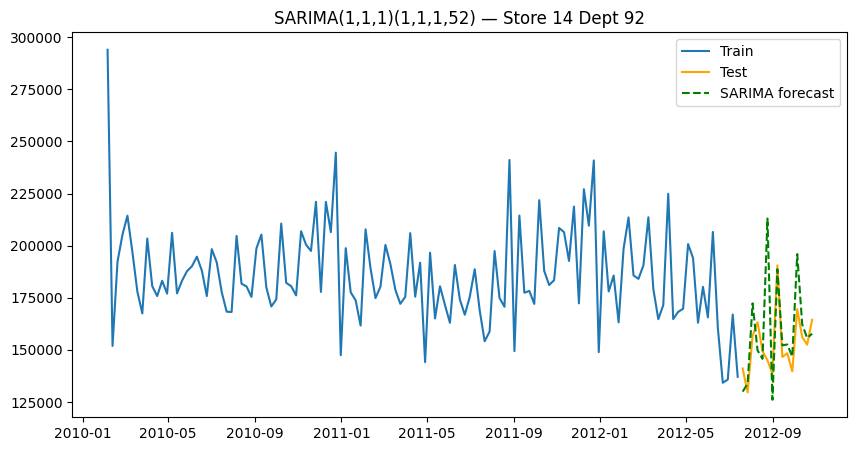

In [31]:

# SARIMA(1,1,1)(1,1,1,52)
sarima_model = sm.tsa.SARIMAX(
    train_y,
    order=(1,1,1),
    seasonal_order=(1,1,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit(disp=False)

# Прогноз
forecast_sarima = sarima_fit.forecast(steps=len(test_y))

# Визуализация
plt.figure(figsize=(10,5))
plt.plot(train_df["Date"], train_y, label="Train")
plt.plot(test_df["Date"], test_y, label="Test", color="orange")
plt.plot(test_df["Date"], forecast_sarima, label="SARIMA forecast", color="green", linestyle="--")
plt.legend()
plt.title("SARIMA(1,1,1)(1,1,1,52) — Store 14 Dept 92")
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_percentage_error

# True values
y_true = test_y
# Predicted values
y_pred = forecast_sarima

# Calculate MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {round(mape*100,2)}")

Mean Absolute Percentage Error (MAPE): 8.41


In [ ]:
best_s = None
best_score = 100
for s in (4,8,13,26,52):
  # SARIMA(1,1,1)(1,1,1,52)
    sarima_model = sm.tsa.SARIMAX(
        train_y,
        order=(1,1,1),
        seasonal_order=(1,1,1,s),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    sarima_fit = sarima_model.fit(disp=False)

    # Прогноз
    y_pred = sarima_fit.forecast(steps=len(test_y))
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    print(f"при s={s} MAPE: {round(mape,2)}")
    if mape < best_score:
        best_score = mape
        best_s = s


In [ ]:
best_s = None
best_score = 100
for s in range(20,41,2):
  # SARIMA(1,1,1)(1,1,1,52)
    sarima_model = sm.tsa.SARIMAX(
        train_y,
        order=(1,1,1),
        seasonal_order=(1,1,1,s),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    sarima_fit = sarima_model.fit(disp=False)

    # Прогноз
    y_pred = sarima_fit.forecast(steps=len(test_y))
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    print(f"при s={s} MAPE: {round(mape,2)}")
    if mape < best_score:
        best_score = mape
        best_s = s

Получили значение лучшей сезонности в 22 недели

In [31]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.3 MB/s eta 0:00:00


In [32]:
!pip install "numpy<2.0"
!pip install --force-reinstall --no-deps pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 76.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>

  Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.3 MB)
  Attempting uninstall: pmdarima
    Found existing installation: pmdarima 2.0.4
    Uninstalling pmdarima-2.0.4:
      Successfully uninstalled pmdarima-2.0.4


In [33]:
import pmdarima as pm

sarima_auto = pm.auto_arima(
    train_y,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    m=22,                # длина сезона
    d=None, D=None,
    seasonal=True,
    stepwise=True,
    trace=True,
    suppress_warnings=True
)

print(sarima_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[22] intercept   : AIC=2939.733, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[22] intercept   : AIC=2945.235, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[22] intercept   : AIC=2945.646, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[22]             : AIC=3473.406, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[22] intercept   : AIC=2941.732, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[22] intercept   : AIC=2941.628, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[22] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[22] intercept   : AIC=2943.286, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[22] intercept   : AIC=2943.678, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[22] intercept   : AIC=2946.145, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[22] intercept
Total fit time: 1.061 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  128
Model:                        SARIMAX   Log Likelihood  

# SARIMAX

In [34]:
features.columns

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')

In [50]:
# Выберем столбцы, которые будут экзогенными (внешними)
exog_cols = ['Date','Temperature', 'Fuel_Price', 'CPI', 'Unemployment',  'IsHoliday']
exog = features.query('Store == 14')[exog_cols]


In [51]:
exog.head()

,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
2366,2010-02-05,27.31,2.784,181.871190,8.992,False
2367,2010-02-12,27.73,2.773,181.982317,8.992,True
2368,2010-02-19,31.27,2.745,182.034782,8.992,False
2369,2010-02-26,34.89,2.754,182.077469,8.992,False
2370,2010-03-05,37.13,2.777,182.120157,8.992,False


In [52]:
exog.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182 entries, 2366 to 2547
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          182 non-null    datetime64[ns]
 1   Temperature   182 non-null    float64       
 2   Fuel_Price    182 non-null    float64       
 3   CPI           169 non-null    float64       
 4   Unemployment  169 non-null    float64       
 5   IsHoliday     182 non-null    bool          
dtypes: bool(1), datetime64[ns](1), float64(4)
memory usage: 8.7 KB


In [53]:
exog['Date'].describe()

,Date
count,182
mean,2011-10-31 12:00:00
min,2010-02-05 00:00:00
25%,2010-12-18 18:00:00
50%,2011-10-31 12:00:00
75%,2012-09-12 06:00:00
max,2013-07-26 00:00:00


In [54]:
df['Date'].describe()

,Date
count,143
mean,2011-06-17 00:00:00
min,2010-02-05 00:00:00
25%,2010-10-11 12:00:00
50%,2011-06-17 00:00:00
75%,2012-02-20 12:00:00
max,2012-10-26 00:00:00


In [55]:
print(len(exog))
print(len(df))

182
143


In [56]:
min_period = df['Date'].min()
max_period = df['Date'].max()
exog = exog[(exog['Date'] >= min_period) & (exog['Date'] <= max_period)]
print(len(exog))

143


Магазин 14, отдел 92

Добились одинаковой размерности основного датафрейма и датафрейма с внешними факторами

In [72]:
train_y = df[:-15]['Weekly_Sales'].reset_index()
train_y = train_y.drop('index', axis = 1)

In [58]:
exog = exog.drop('Date', axis = 1)

In [62]:
exog['IsHoliday'] = exog['IsHoliday'].astype(int)
exog.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, 2366 to 2508
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Temperature   143 non-null    float64
 1   Fuel_Price    143 non-null    float64
 2   CPI           143 non-null    float64
 3   Unemployment  143 non-null    float64
 4   IsHoliday     143 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.7 KB


In [69]:
exog_train = exog[:-15][['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',  'IsHoliday']].reset_index()

In [75]:
exog_train = exog_train.drop('index', axis = 1)
exog_train

,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,27.31,2.784,181.871190,8.992,0
1,27.73,2.773,181.982317,8.992,1
2,31.27,2.745,182.034782,8.992,0
3,34.89,2.754,182.077469,8.992,0
4,37.13,2.777,182.120157,8.992,0
...,...,...,...,...,...
123,71.93,3.620,191.029973,8.567,0
124,74.22,3.564,191.064610,8.567,0
125,75.22,3.506,191.099246,8.567,0
126,82.99,3.475,191.133883,8.684,0


In [61]:
exog_train.isnull().sum()

,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0
IsHoliday,0


In [76]:
sarimax_model = sm.tsa.SARIMAX(
    endog=train_y,          # сам временной ряд (продажи)
    exog=exog_train,           # внешние признаки
    order=(1,1,1),          # обычные параметры ARIMA (p,d,q)
    seasonal_order=(1,1,1,22),  # сезонные параметры (P,D,Q,s), где s=52 недели = 1 год
    enforce_stationarity=False,  # отключаем жёсткую проверку стационарности
    enforce_invertibility=False  # отключаем жёсткую проверку обратимости
)

# Обучаем модель (fit = подгонка параметров)
sarimax_fit = sarimax_model.fit(disp=False)


In [77]:
exog_test = exog[-15:][['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',  'IsHoliday']].reset_index()
exog_test = exog_test.drop('index', axis = 1)
exog_test

,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,78.89,3.567,191.167043,8.684,0
1,77.20,3.647,191.165566,8.684,0
2,76.58,3.654,191.164090,8.684,0
3,78.65,3.722,191.162613,8.684,0
4,75.71,3.807,191.228492,8.684,0
5,72.62,3.834,191.344887,8.684,0
6,75.09,3.867,191.461281,8.684,0
7,75.70,3.911,191.577676,8.684,1
8,67.87,3.948,191.699850,8.684,0
9,65.32,4.038,191.856704,8.684,0


In [79]:
# Прогнозируем столько же недель, сколько есть в тесте
forecast_sarimax = sarimax_fit.predict(
    start=len(train_y),                      # начало прогноза
    end=len(train_y) + len(test_y) - 1,      # конец прогноза
    exog=exog_test                          # внешние признаки для будущего
)


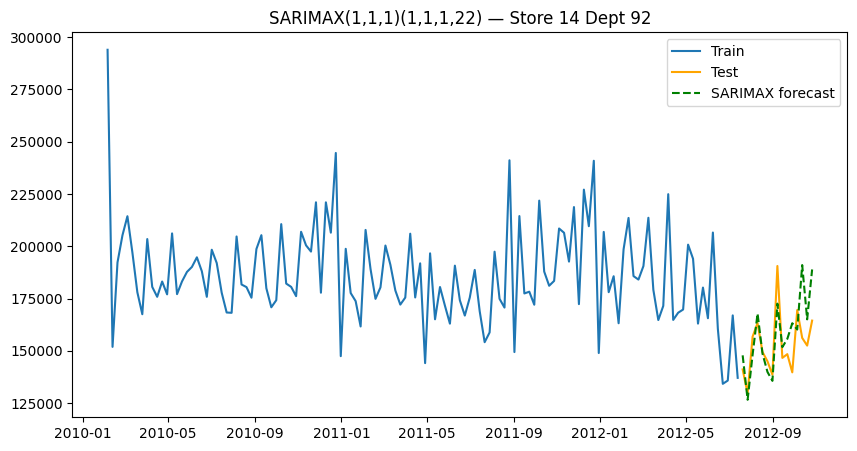

In [81]:

# Визуализация
plt.figure(figsize=(10,5))
plt.plot(train_df["Date"], train_y, label="Train")
plt.plot(test_df["Date"], test_y, label="Test", color="orange")
plt.plot(test_df["Date"], forecast_sarimax, label="SARIMAX forecast", color="green", linestyle="--")
plt.legend()
plt.title("SARIMAX(1,1,1)(1,1,1,22) — Store 14 Dept 92")
plt.show()

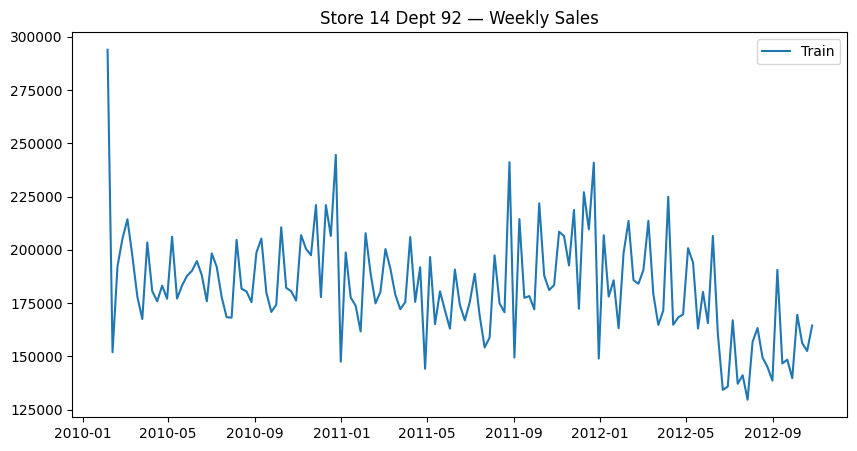

In [82]:
# Посмотрим на график
plt.figure(figsize=(10,5))
plt.plot(df["Date"], df["Weekly_Sales"], label="Train")
plt.legend()
plt.title("Store 14 Dept 92 — Weekly Sales")
plt.show()

In [83]:
# True values
y_true = test_y
# Predicted values
y_pred = forecast_sarimax

# Calculate MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {round(mape*100,2)}")

Mean Absolute Percentage Error (MAPE): 7.15


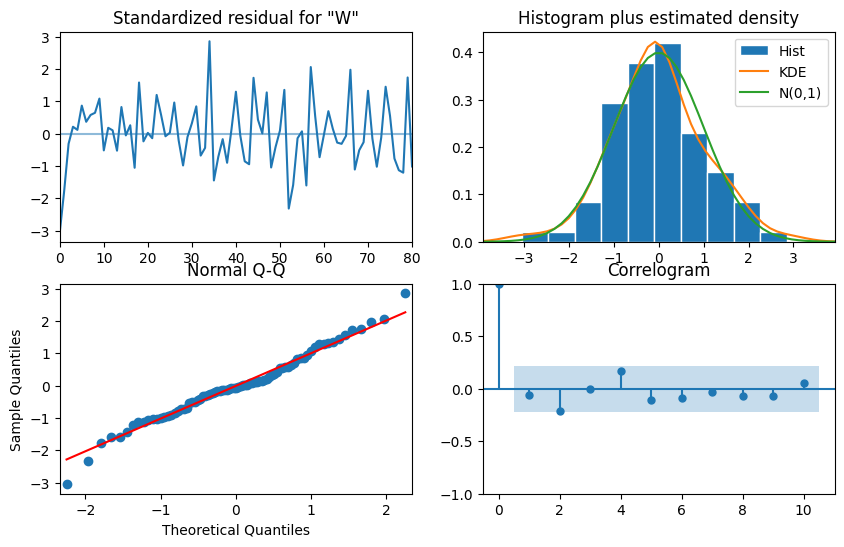

In [84]:
sarimax_fit.plot_diagnostics(figsize=(10,6))
plt.show()


# SARIMAX после нормализации экзогенов

In [85]:
from sklearn.preprocessing import StandardScaler

In [86]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(exog_train),
    index=exog_train.index, columns=['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',  'IsHoliday']
)

X_test_scaled = pd.DataFrame(
    scaler.transform(exog_test),
    index=exog_test.index, columns=['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',  'IsHoliday']
)

X_train_scaled

,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,-1.777620,-1.334914,-1.166487,2.179815,-0.275010
1,-1.751967,-1.360130,-1.132230,2.179815,3.636237
2,-1.535746,-1.424316,-1.116057,2.179815,-0.275010
3,-1.314639,-1.403685,-1.102898,2.179815,-0.275010
4,-1.177821,-1.350960,-1.089739,2.179815,-0.275010
...,...,...,...,...,...
123,0.947742,0.581511,1.656825,-0.491130,-0.275010
124,1.087614,0.453138,1.667502,-0.491130,-0.275010
125,1.148693,0.320180,1.678179,-0.491130,-0.275010
126,1.623280,0.249117,1.688857,0.244166,-0.275010


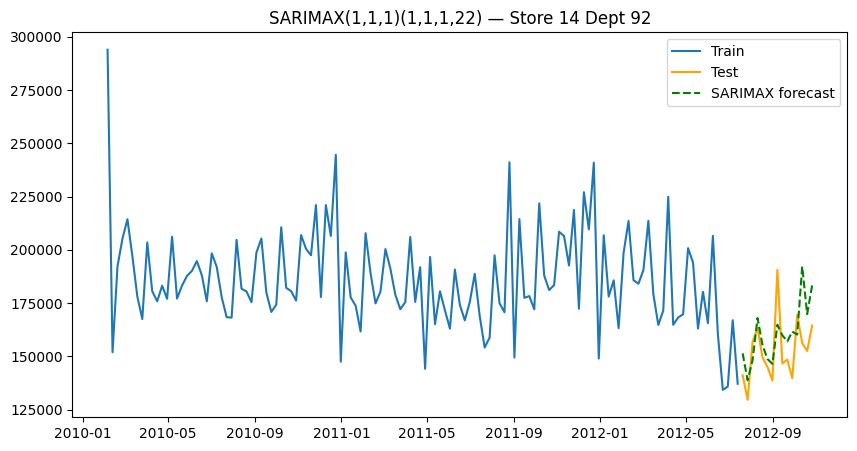

In [100]:
sarimax_model = sm.tsa.SARIMAX(
    endog=train_y,          # сам временной ряд (продажи)
    exog=X_train_scaled,           # внешние признаки
    order=(1,1,1),          # обычные параметры ARIMA (p,d,q)
    seasonal_order=(1,1,1,22),  # сезонные параметры (P,D,Q,s), где s=52 недели = 1 год
    enforce_stationarity=False,  # отключаем жёсткую проверку стационарности
    enforce_invertibility=False  # отключаем жёсткую проверку обратимости
)

# Обучаем модель (fit = подгонка параметров)
sarimax_fit = sarimax_model.fit(disp=False)

# Прогнозируем столько же недель, сколько есть в тесте
forecast_sarimax = sarimax_fit.predict(
    start=len(train_y),                      # начало прогноза
    end=len(train_y) + len(test_y) - 1,      # конец прогноза
    exog=X_test_scaled                          # внешние признаки для будущего
)


# Визуализация
plt.figure(figsize=(10,5))
plt.plot(train_df["Date"], train_y, label="Train")
plt.plot(test_df["Date"], test_y, label="Test", color="orange")
plt.plot(test_df["Date"], forecast_sarimax, label="SARIMAX forecast", color="green", linestyle="--")
plt.legend()
plt.title("SARIMAX(1,1,1)(1,1,1,22) — Store 14 Dept 92")
plt.show()

In [101]:
# True values
y_true = test_y
# Predicted values
y_pred = forecast_sarimax

# Calculate MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {round(mape*100,2)}")

Mean Absolute Percentage Error (MAPE): 8.67


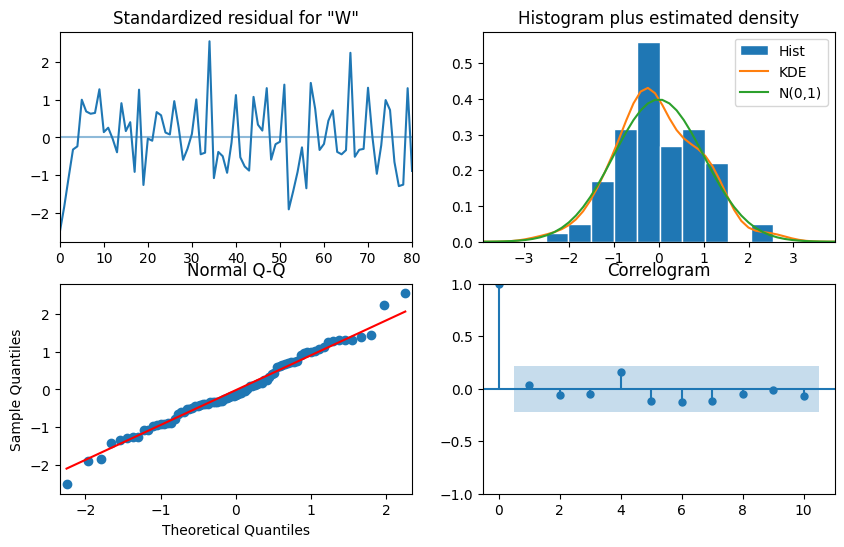

In [91]:
sarimax_fit.plot_diagnostics(figsize=(10,6))
plt.show()

In [94]:
import seaborn as sns

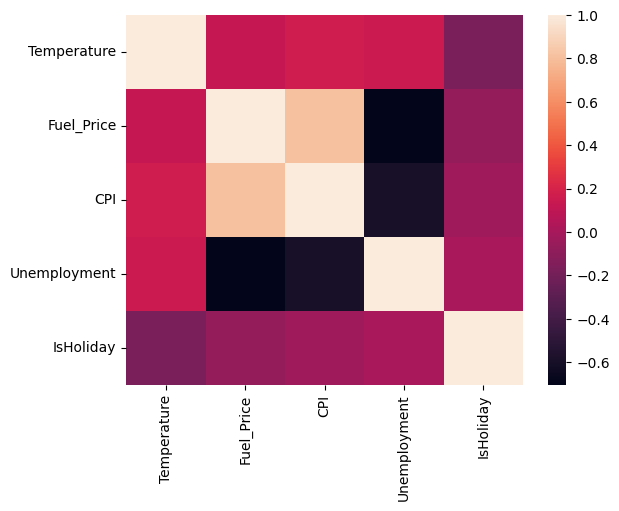

In [95]:
corr = exog.corr()
sns.heatmap(corr);

In [96]:
exog.columns

Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday'], dtype='object')

# Sarimax где всего лишь 3 внешних фактора

In [97]:
need_cols = ['Temperature', 'Fuel_Price', 'IsHoliday']

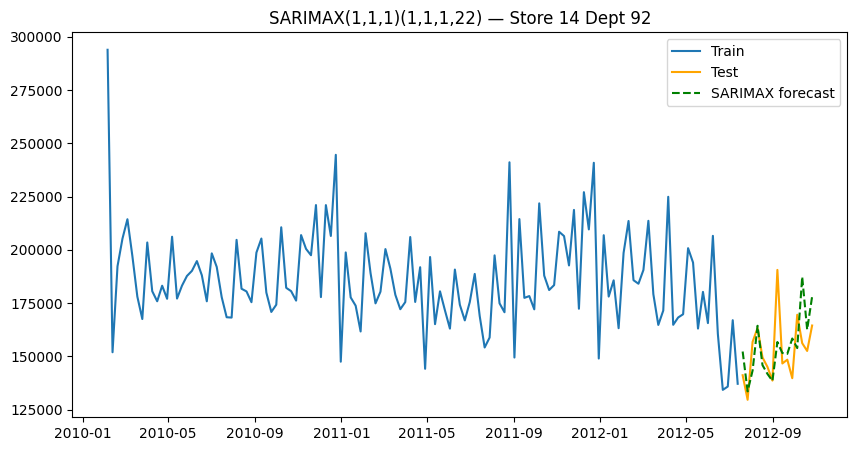

In [98]:
sarimax_model = sm.tsa.SARIMAX(
    endog=train_y,          # сам временной ряд (продажи)
    exog=X_train_scaled[need_cols],           # внешние признаки
    order=(1,1,1),          # обычные параметры ARIMA (p,d,q)
    seasonal_order=(1,1,1,22),  # сезонные параметры (P,D,Q,s), где s=52 недели = 1 год
    enforce_stationarity=False,  # отключаем жёсткую проверку стационарности
    enforce_invertibility=False  # отключаем жёсткую проверку обратимости
)

# Обучаем модель (fit = подгонка параметров)
sarimax_fit = sarimax_model.fit(disp=False)

# Прогнозируем столько же недель, сколько есть в тесте
forecast_sarimax = sarimax_fit.predict(
    start=len(train_y),                      # начало прогноза
    end=len(train_y) + len(test_y) - 1,      # конец прогноза
    exog=X_test_scaled[need_cols]                         # внешние признаки для будущего
)


# Визуализация
plt.figure(figsize=(10,5))
plt.plot(train_df["Date"], train_y, label="Train")
plt.plot(test_df["Date"], test_y, label="Test", color="orange")
plt.plot(test_df["Date"], forecast_sarimax, label="SARIMAX forecast", color="green", linestyle="--")
plt.legend()
plt.title("SARIMAX(1,1,1)(1,1,1,22) — Store 14 Dept 92")
plt.show()

In [99]:
# True values
y_true = test_y
# Predicted values
y_pred = forecast_sarimax

# Calculate MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {round(mape*100,2)}")

Mean Absolute Percentage Error (MAPE): 7.02


вывод - отбор внешних признаков помог

# SARIMAX с оптимальными параметрами

In [102]:
# Годовая недельная сезонность
SEASON = 22

# Аккуратные границы поиска: не слишком узкие и не безумные
model_auto = pm.auto_arima(
    y=train_y,
    exogenous=X_train_scaled[need_cols],   # экзогены — уже в масштабе
    start_p=0, max_p=3,         # не-сезонная AR часть
    start_q=0, max_q=3,         # не-сезонная MA часть
    d=None,                     # подберёт необходимость разности сам (ADF/KPSS)
    start_P=0, max_P=2,         # сезонная AR
    start_Q=0, max_Q=2,         # сезонная MA
    D=None,                     # подберёт сезонную разность
    seasonal=True,
    m=SEASON,                   # длина сезона (52 недели)
    stepwise=True,              # быстрый пошаговый перебор
    trace=True,                 # печать хода поиска (видно AIC)
    information_criterion="aic",
    n_fits=50,                  # ограничим число подгонок (страхуем время)
    error_action="ignore",
    suppress_warnings=True
)

print(model_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[22] intercept   : AIC=2939.733, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[22] intercept   : AIC=2945.235, Time=0.34 sec
 ARIMA(0,0,1)(0,0,1)[22] intercept   : AIC=2945.646, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[22]             : AIC=3473.406, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[22] intercept   : AIC=2941.732, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[22] intercept   : AIC=2941.628, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[22] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[22] intercept   : AIC=2943.286, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[22] intercept   : AIC=2943.678, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[22] intercept   : AIC=2946.145, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[22] intercept
Total fit time: 0.963 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  128
Model:                        SARIMAX   Log Likelihood  

In [ ]:
best_mape = 1
best_params = None
for p in (0,1,2):
  for d in (0,1,2):
    for q in (0,1,2):
      for P in (0,1,2):
        for D in (0,1,2):
          for Q in (0,1,2):
              sarimax_model = sm.tsa.SARIMAX(
              endog=train_y,          # сам временной ряд (продажи)
              exog=X_train_scaled[need_cols],           # внешние признаки
              order=(p,d,q),          # обычные параметры ARIMA (p,d,q)
              seasonal_order=(P,D,Q,22),  # сезонные параметры (P,D,Q,s), где s=52 недели = 1 год
              enforce_stationarity=False,  # отключаем жёсткую проверку стационарности
              enforce_invertibility=False  # отключаем жёсткую проверку обратимости
              )

              # Обучаем модель (fit = подгонка параметров)
              sarimax_fit = sarimax_model.fit(disp=False)

              # Прогнозируем столько же недель, сколько есть в тесте
              forecast_sarimax = sarimax_fit.predict(
                  start=len(train_y),                      # начало прогноза
                  end=len(train_y) + len(test_y) - 1,      # конец прогноза
                  exog=X_test_scaled[need_cols]                         # внешние признаки для будущего
              )
              y_true = test_y
              # Predicted values
              y_pred = forecast_sarimax

              # Calculate MAPE
              mape = mean_absolute_percentage_error(y_true, y_pred)
              # print(f"При P,D,Q = {P,D,Q} mape = {round(mape*100,2)}")
              if mape < best_mape:
                  best_mape = mape
                  best_params = [p,d,q,P,D,Q]

print('-----------------------------------')
print(f"лучший MAPE = {round(mape*100,2)} при параметрах = {best_params}")